2025-05-13 10:10:44.343032: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 10:10:44.349692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747156244.357259   86173 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747156244.359557   86173 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747156244.365533   86173 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3008
  Validation Loss     : 0.8050
  Semantic Similarity : 0.3757


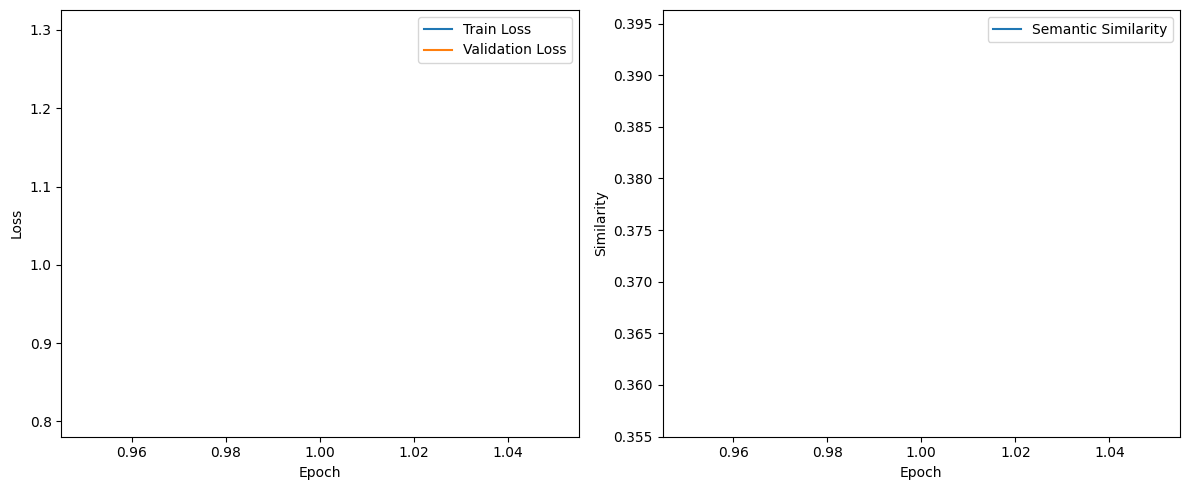

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.8727
Test Semantic Similarity: 0.4036

--- Example 39 ---
Raw Report       : 
[ Finding ]_x000D_
Joint space narrowing with sclerotic changes in intertarsal joint with loose body._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Joint space narrowing with sclerotic changes in intertarsal joint with loose body.
Generated Report : 
degenerative change.

--- Example 29 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
Gouty arthritis in Rt 1st and left 5th MTP._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Gouty arthritis in Rt 1st and left 5th MTP.
Generated Report : 
no bony lesion.

--- Example 105 ---
Raw Report       : 
[ Finding ]_x000D_
postop. state._x000D_
degenerative change._x000D_
[ Conclusion ]_x000D_
postop. state._x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
postop. state. degenerative change.
Generated Report : 
degenerative 

In [1]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt


# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
# 1) Remove any existing handlers (e.g. from prior imports or notebook runs)
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)

# 2) Configure file-only logging
logging.basicConfig(
    filename='training.log',      # will be created in your current working directory
    filemode='w',                 # overwrite on each run
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"Findings: {clean}"
        tok = self.tokenizer(input_text, truncation=True, max_length=511, return_tensors='pt')

        if tok['input_ids'][0][-1] != self.tokenizer.eos_token_id:
            input_ids = torch.cat([tok['input_ids'], torch.tensor([[self.tokenizer.eos_token_id]])], dim=1)
            attention_mask = torch.cat([tok['attention_mask'], torch.tensor([[1]])], dim=1)
        else:
            input_ids = tok['input_ids']
            attention_mask = tok['attention_mask']

        input_ids = input_ids.squeeze(0)
        attention_mask = attention_mask.squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }


    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] stacked full_imgs shape: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] stacked patches shape: {patches.shape}")

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] padded input_ids shape: {ids.shape}, padded attention_mask shape: {masks.shape}")

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # Global image
        g_feats = self.global_encoder(imgs)
        logging.info(f"[Model] global_encoder output shape: {g_feats.shape}")
        g = self.global_proj(g_feats).unsqueeze(1)
        logging.info(f"[Model] global_proj + unsqueeze shape: {g.shape}")

        # Patch images
        B, N, C, H, W = patches.shape
        logging.info(f"[Model] patches input shape: {patches.shape}")
        p = patches.view(B * N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        logging.info(f"[Model] patch_encoder output shape: {pf_feats.shape}")
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)
        logging.info(f"[Model] patch_proj + reshape shape: {pf.shape}")

        # Combine
        cat = torch.cat([g, pf], dim=1)
        logging.info(f"[Model] concatenated features shape: {cat.shape}")
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)
        logging.info(f"[Model] after attention & norm shape: {comb.shape}")

        # Decoder
        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        logging.info(f"[Model] decoder logits shape: {out.logits.shape}")
        return out

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        logging.info(f"[Train] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}, mask {msk.shape}")

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        logging.info(f"[Eval] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}")

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # Use consistent prompt
            prompt_text = "Findings:"
            prompt_ids = tokenizer(prompt_text, return_tensors='pt')['input_ids'].to(device)
            prompt = prompt_ids.repeat(imgs.size(0), 1)

            # Encode images
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            gen_ids = model.decoder.generate(
                input_ids=prompt,
                encoder_hidden_states=comb,
                early_stopping=True,
                attention_mask=torch.ones_like(prompt),
                max_length=100,
                do_sample=True,
                top_k=40,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                no_repeat_ngram_size=2,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )

            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True).replace("Findings:", "").strip() for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True).replace("Findings:", "").strip() for i_ in ids]

            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt


def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

# Initialize and configure tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Prepare dataset
dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
logging.info("Dataset class distribution:")
for cls, cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

# Split
n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Model, optimizer, scheduler, scaler
model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.amp.GradScaler()

# Training
num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    logging.info(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    logging.info(f"  Train Loss          : {train_loss:.4f}")
    logging.info(f"  Validation Loss     : {val_loss:.4f}")
    logging.info(f"  Semantic Similarity : {sem:.4f}")

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Plot metrics
plot_metrics(train_losses, val_losses, sems)

# Test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
logging.info("\n========== TEST RESULTS ==========")
logging.info(f"Test Loss               : {test_loss:.4f}")
logging.info(f"Test Semantic Similarity: {test_sem:.4f}")

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

logging.info("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)

    prompt_text = "Findings:"
    prompt_ids = tokenizer(prompt_text, return_tensors='pt')['input_ids'].to(device)
    prompt = prompt_ids.repeat(fi.size(0), 1)

    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B, N, 768)
    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    gen_ids = model.decoder.generate(
        input_ids=prompt,
        encoder_hidden_states=comb,
        early_stopping=True,
        attention_mask=torch.ones_like(prompt),
        max_length=100,
        do_sample=True,
        top_k=40,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        no_repeat_ngram_size=2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True).replace("Findings:", "").strip()

    logging.info(f"\n--- Example {idx} ---")
    logging.info(f"Raw Report       : \n{raw}")
    logging.info(f"Cleaned Report   : \n{clean}")
    logging.info(f"Generated Report : \n{gen}")

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")



Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4058
  Validation Loss     : 0.9173
  Semantic Similarity : 0.1761


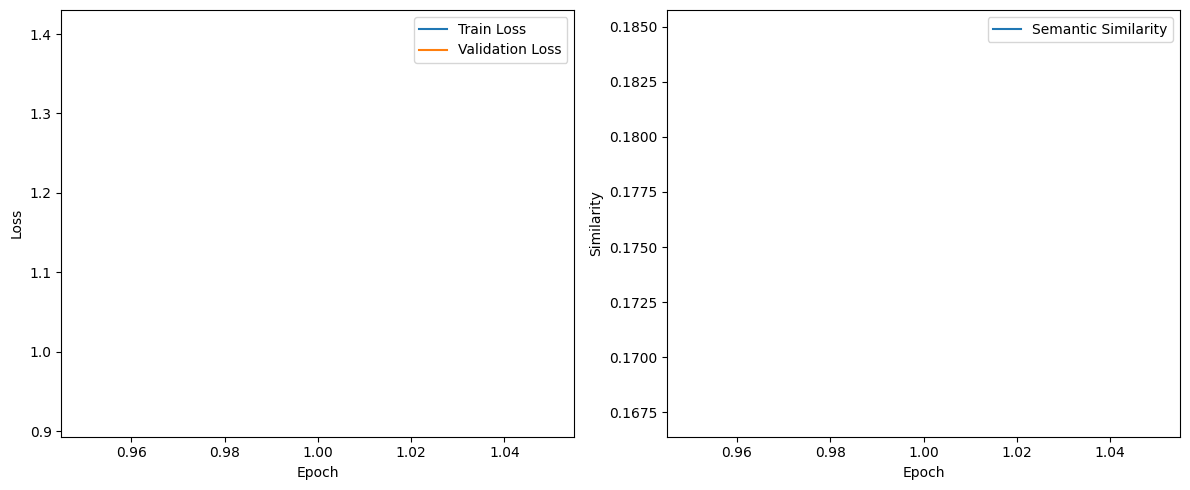

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.9260
Test Semantic Similarity: 0.1794

--- Example 113 ---
Raw Report       : 
[FINDING       ]_x000D_Degenerative changes_x000D__x000D_[CONCLUSION    ]_x000D_Degenerative changes_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   : 
Degenerative changes
Generated Report : 
FINDINGS:

--- Example 108 ---
Raw Report       : 
[ Finding ]_x000D_
both hands, ankles, and feet, degenerative change._x000D_
_x000D_
[ Conclusion ]_x000D_
both hands, ankles, and feet, degenerative change._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
both hands, ankles, and feet, degenerative change.
Generated Report : 
FINDINGS:

--- Example 21 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
Enthesopathy in both calcaneus._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Enthesopathy in both calcaneus.
Generated Report : 
FINDINGS:

--- Example 6 ---
Raw Report       : 
[ Finding ]_x000D_
no significant interv

In [2]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)

logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================

def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================

class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} {clean}"
        tok = self.tokenizer(input_text, truncation=True, max_length=511, return_tensors='pt')

        if tok['input_ids'][0][-1] != self.tokenizer.eos_token_id:
            input_ids = torch.cat([tok['input_ids'], torch.tensor([[self.tokenizer.eos_token_id]])], dim=1)
            attention_mask = torch.cat([tok['attention_mask'], torch.tensor([[1]])], dim=1)
        else:
            input_ids = tok['input_ids']
            attention_mask = tok['attention_mask']

        input_ids = input_ids.squeeze(0)
        attention_mask = attention_mask.squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img': img,
            'patches': patches_tensor,
            'raw_report': raw,
            'cleaned_report': clean,
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'): left = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left', 'right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side == 'left': left = lst
                            else: right = lst

        if left and not right:
            right = [cv2.flip(p, 1) for p in left]
        if right and not left:
            left = [cv2.flip(p, 1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE | re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE | re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        text = re.sub(r'\s+', ' ', text).strip()
        return text

# =============================================================================
# Collate function
# =============================================================================

def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] stacked full_imgs shape: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] stacked patches shape: {patches.shape}")

    ids = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] padded input_ids shape: {ids.shape}, padded attention_mask shape: {masks.shape}")

    return {
        'full_imgs': imgs,
        'patches': patches,
        'input_ids': ids,
        'attention_mask': masks,
        'raw_reports': [b['raw_report'] for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model
# =============================================================================

class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)

        self.decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2, 3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        # Global image
        g_feats = self.global_encoder(imgs)
        logging.info(f"[Model] global_encoder output shape: {g_feats.shape}")
        g = self.global_proj(g_feats).unsqueeze(1)
        logging.info(f"[Model] global_proj + unsqueeze shape: {g.shape}")

        # Patch images
        B, N, C, H, W = patches.shape
        logging.info(f"[Model] patches input shape: {patches.shape}")
        p = patches.view(B * N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        logging.info(f"[Model] patch_encoder output shape: {pf_feats.shape}")
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)
        logging.info(f"[Model] patch_proj + reshape shape: {pf.shape}")

        # Combine
        cat = torch.cat([g, pf], dim=1)
        logging.info(f"[Model] concatenated features shape: {cat.shape}")
        comb, _ = self.attn(cat, cat, cat)
        comb = self.norm(comb)
        logging.info(f"[Model] after attention & norm shape: {comb.shape}")

        # Decoder
        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        logging.info(f"[Model] decoder logits shape: {out.logits.shape}")
        return out

# =============================================================================
# Train / Eval helpers
# =============================================================================

def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.0
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        logging.info(f"[Train] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}, mask {msk.shape}")

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        logging.info(f"[Eval] batch full_imgs {imgs.shape}, patches {pts.shape}, input_ids {ids.shape}")

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # build the visual context reuse
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B, N, C, H, W = pts.shape
            p = pts.view(B * N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat = torch.cat([g, pf], dim=1)
            comb, _ = model.attn(cat, cat, cat)
            comb = model.norm(comb)

            # Prepare FINDINGS: prompt
            prompt_ids = tokenizer(
                "FINDINGS:",
                return_tensors="pt",
                add_special_tokens=False
            ).input_ids.to(device)              # (1, L)
            prompt_ids = prompt_ids.expand(B, -1)  # (B, L)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, sems, label="Semantic Similarity")
    plt.xlabel("Epoch")
    plt.ylabel("Similarity")
    plt.legend()

    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================

class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['ra', 'oa', 'gout', 'normal', 'uncertain', 'ref.prev']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
logging.info("Dataset class distribution:")
for cls, cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.amp.GradScaler()

num_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    logging.info(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    logging.info(f"  Train Loss          : {train_loss:.4f}")
    logging.info(f"  Validation Loss     : {val_loss:.4f}")
    logging.info(f"  Semantic Similarity : {sem:.4f}")

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# Test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)
logging.info("\n========== TEST RESULTS ==========")
logging.info(f"Test Loss               : {test_loss:.4f}")
logging.info(f"Test Semantic Similarity: {test_sem:.4f}")

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random test examples
logging.info("\n===== RANDOM TEST EXAMPLES =====")
for idx in random.sample(range(len(test_ds)), min(10, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)

    # Visual context
    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B, N, C, H, W = pa.shape
    p = pa.view(B * N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B, N, 768)
    cat = torch.cat([g, pf], dim=1)
    comb, _ = model.attn(cat, cat, cat)
    comb = model.norm(comb)

    # FINDINGS: prompt
    prompt_ids = tokenizer(
        "FINDINGS:",
        return_tensors="pt",
        add_special_tokens=False
    ).input_ids.to(device)             # (1, L)
    prompt_mask = torch.ones_like(prompt_ids, device=device)

    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    logging.info(f"\n--- Example {idx} ---")
    logging.info(f"Raw Report       : \n{raw}")
    logging.info(f"Cleaned Report   : \n{clean}")
    logging.info(f"Generated Report : \n{gen}")

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1713
  Validation Loss     : 0.8442
  Semantic Similarity : 0.4435


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.7300
  Validation Loss     : 0.7557
  Semantic Similarity : 0.4816


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.6344
  Validation Loss     : 0.7205
  Semantic Similarity : 0.4666


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.5757
  Validation Loss     : 0.7080
  Semantic Similarity : 0.4581


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.5232
  Validation Loss     : 0.7011
  Semantic Similarity : 0.4660


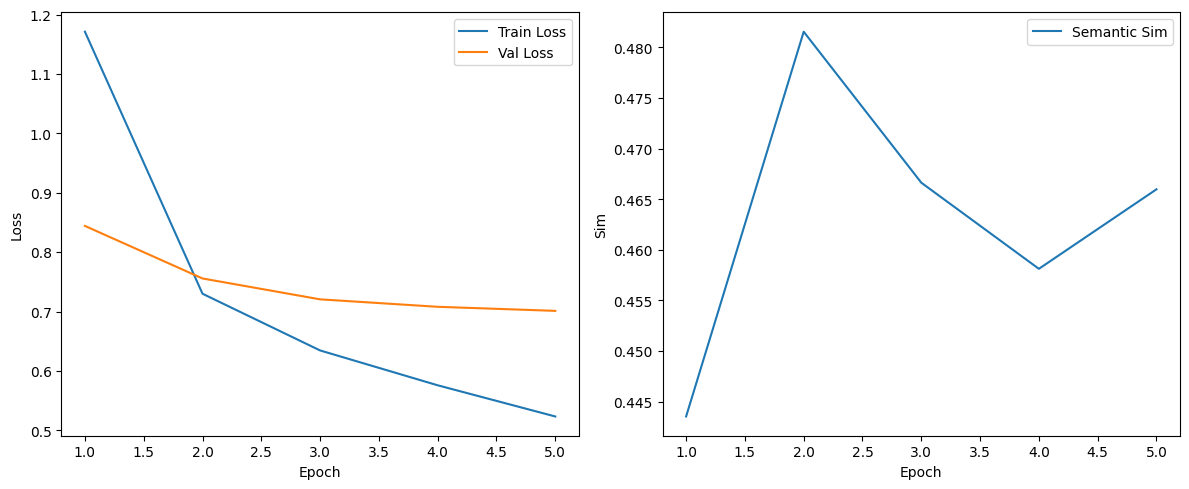

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.6444
Test Semantic Similarity: 0.4657

--- Example 104 ---
Raw Report       : 
[ Finding ]_x000D_
No bony abnormality._x000D_
[ Diagnosis ]_x000D_
No bony abnormality._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
No bony abnormality. No bony abnormality.
Generated Report : 
FINDINGS: Rt. 1st PP head, suspicious erosion --> gout arthritis cannot be excluded 

--- Example 164 ---
Raw Report       : 
[ Finding ]_x000D_
No bony abnormality._x000D_
[ Diagnosis ]_x000D_
No bony abnormality._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
No bony abnormality. No bony abnormality.
Generated Report : 
FINDINGS: No bony abnormality 

--- Example 20 ---
Raw Report       : 
[FINDING       ]_x000D_-_x000D__x000D_[CONCLUSION    ]_x000D_no significant bony abnormality_x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   : 
- no significant bony abnormality
Generated Report : 
FINDINGS: no significant bony abnormality 

--- Example

In [5]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (unchanged)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # <<<— CHANGED: prepend FINDINGS: so the model learns to generate after it
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()


# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition (unchanged)
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p     = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled= self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1), torch.cat([g,pf],1), torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (mostly unchanged, except decode)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context for generation
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_  = model.attn(torch.cat([g,pf],1), torch.cat([g,pf],1), torch.cat([g,pf],1))
            comb    = model.norm(cat)

            # <<<— CHANGED: decode with FINDINGS: prefix
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout()
    plt.show()

# =============================================================================
# MAIN
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON          = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW       = True
cfg.DATASET.USE_PATCH     = True
cfg.DATASET.REPORT        = True
cfg.DATASET.TARGET_CLASSES= ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE      = False
cfg.DATASET.AUGMENT      = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n        = len(dataset)
n_train  = int(0.8 * n)
n_val    = int(0.1 * n)
n_test   = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model     = MultiModalModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

num_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    logging.info(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    #print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Sem Sim: {sem:.4f}")

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")

    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# random examples
for idx in random.sample(range(len(test_ds)), min(10,len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N,C,H,W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1), torch.cat([g,pf],1), torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # <<<— CHANGED: generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


In [6]:
for idx in random.sample(range(len(test_ds)), min(30,len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N,C,H,W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1), torch.cat([g,pf],1), torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # <<<— CHANGED: generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


--- Example 178 ---
Raw Report       : 
[ Finding ]_x000D_
RA, both hands and feet with erosion._x000D_
[ Conclusion ]_x000D_
RA, both hands and feet with erosion._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
RA, both hands and feet with erosion.
Generated Report : 
FINDINGS: no bony lesion. 

--- Example 120 ---
Raw Report       : 
[ Finding ]_x000D_
gout, both 1st MTP joints._x000D_
[ Diagnosis ]_x000D_
gout, both 1st MTP joints._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
gout, both 1st MTP joints. gout, both 1st MTP joints.
Generated Report : 
FINDINGS: both feet, no significant bony lesion on radiographs. 

--- Example 76 ---
Raw Report       : 
[ Finding ]_x000D_
포함된 bone에 이상소견은 보이지 않음._x000D_
보이는 한도내에 soft tissue에 이상소견 보이지 않음._x000D_
[ Diagnosis ]_x000D_
No bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
bone . soft tissue . No bony abnormality
Generated Report : 
FINDINGS: No bony abnormality. 

--- Example 2 ---
Raw Report       : 
[ Finding ]_x000D

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


-- Phase 1, Epoch 1/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.7527
  Validation Loss     : 1.2028
  Semantic Similarity : 0.4955

-- Phase 1, Epoch 2/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3945
  Validation Loss     : 1.1270
  Semantic Similarity : 0.4768

-- Phase 1, Epoch 3/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3699
  Validation Loss     : 1.0924
  Semantic Similarity : 0.4989

-- Phase 1, Epoch 4/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3138
  Validation Loss     : 1.0620
  Semantic Similarity : 0.5134

-- Phase 1, Epoch 5/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2921
  Validation Loss     : 1.0522
  Semantic Similarity : 0.4837

-- Phase 1, Epoch 6/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2769
  Validation Loss     : 1.0364
  Semantic Similarity : 0.4958

-- Phase 1, Epoch 7/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2246
  Validation Loss     : 1.0088
  Semantic Similarity : 0.4933

-- Phase 1, Epoch 8/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2136
  Validation Loss     : 1.0011
  Semantic Similarity : 0.4839

-- Phase 1, Epoch 9/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1884
  Validation Loss     : 0.9858
  Semantic Similarity : 0.5243

-- Phase 1, Epoch 10/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1949
  Validation Loss     : 0.9880
  Semantic Similarity : 0.5138


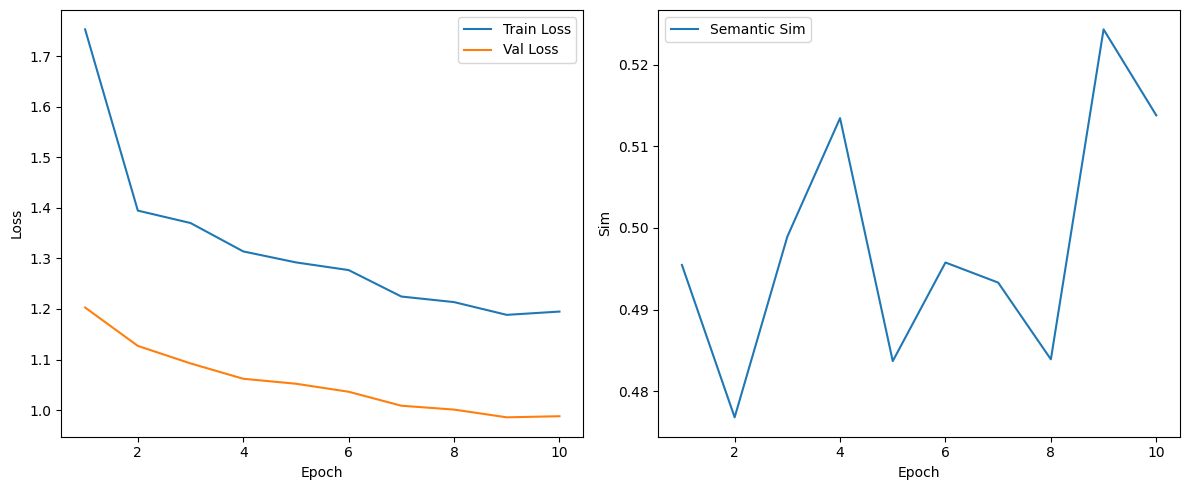


-- Phase 2, Epoch 1/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1477
  Validation Loss     : 0.9537
  Semantic Similarity : 0.5210

-- Phase 2, Epoch 2/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1134
  Validation Loss     : 0.9314
  Semantic Similarity : 0.5011

-- Phase 2, Epoch 3/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0890
  Validation Loss     : 0.9142
  Semantic Similarity : 0.5007

-- Phase 2, Epoch 4/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0664
  Validation Loss     : 0.9048
  Semantic Similarity : 0.5041

-- Phase 2, Epoch 5/5 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0697
  Validation Loss     : 0.9029
  Semantic Similarity : 0.5106


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 1.0194
Test Semantic Similarity: 0.5148

--- Example 39 ---
Raw Report       : 
[ Finding ]_x000D_
No bony abnormality_x000D_
_x000D_
[ Diagnosis ]_x000D_
No bony abnormality_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
No bony abnormality No bony abnormality
Generated Report : 
FINDINGS: degenerative change. 

--- Example 173 ---
Raw Report       : 
[FINDING       ]_x000D_degenerative change

both knee joint effusion.

both wrist, joint space narrowing and suspicious erosion
   --> R/O RA

cervical spondylosis.
disc space narrowing, C5/6 with both neural foraminal stenosis.
cervical straightening._x000D__x000D_[CONCLUSION    ]_x000D_degenerative change

both knee joint effusion.

both wrist, joint space narrowing and suspicious erosion
   --> R/O RA

cervical spondylosis.
disc space narrowing, C5/6 with both neural foraminal stenosis.
cervical straightening._x000D__x000D_[RECOMMENDATION]_x000D_-
Cleaned Report   : 
dege

In [ ]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (unchanged)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (with FINDINGS: prefix in __getitem__)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # <<<— CHANGED: prepend FINDINGS: so model learns after it
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    # _gen_patches and _clean_report methods as before...
    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition (unchanged)
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p     = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled= self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (unchanged decode with FINDINGS:)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_  = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb    = model.norm(cat)

            # <<<— CHANGED: decode with FINDINGS: prefix
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with freeze/unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# =============================================================================
# Phase 1: freeze GPT-2 body, train only global_proj, patch_proj, cross-attn
# =============================================================================
for name, p in model.decoder.named_parameters():
    p.requires_grad = False
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True
for name, p in model.decoder.named_parameters():
    if "crossattention" in name.lower():
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 10
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze entire GPT-2, low‐LR fine‐tune
# =============================================================================
for p in model.decoder.parameters():
    p.requires_grad = True

# rebuild optimizer for full fine-tune
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 5
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # build visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


-- Phase 1, Epoch 1/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.7461
  Validation Loss     : 1.2250
  Semantic Similarity : 0.4190

-- Phase 1, Epoch 2/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.4226
  Validation Loss     : 1.1668
  Semantic Similarity : 0.4556

-- Phase 1, Epoch 3/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3595
  Validation Loss     : 1.1287
  Semantic Similarity : 0.4982

-- Phase 1, Epoch 4/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.3259
  Validation Loss     : 1.1137
  Semantic Similarity : 0.4877

-- Phase 1, Epoch 5/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2957
  Validation Loss     : 1.0972
  Semantic Similarity : 0.4897

-- Phase 1, Epoch 6/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2688
  Validation Loss     : 1.0910
  Semantic Similarity : 0.4816

-- Phase 1, Epoch 7/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2414
  Validation Loss     : 1.0791
  Semantic Similarity : 0.5175

-- Phase 1, Epoch 8/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2275
  Validation Loss     : 1.0530
  Semantic Similarity : 0.4974

-- Phase 1, Epoch 9/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.2173
  Validation Loss     : 1.0463
  Semantic Similarity : 0.4946

-- Phase 1, Epoch 10/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1976
  Validation Loss     : 1.0509
  Semantic Similarity : 0.4931


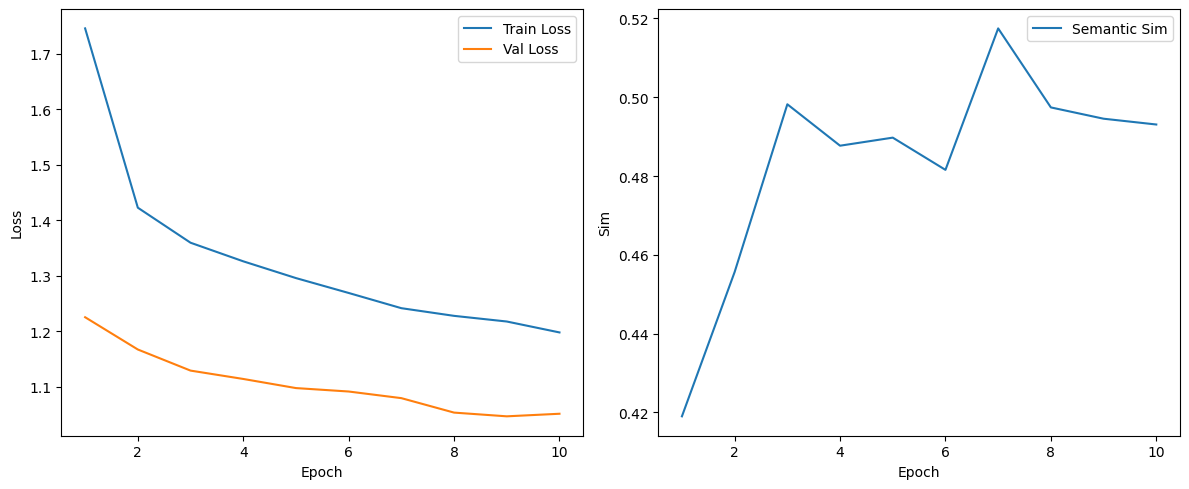


-- Phase 2, Epoch 1/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1764
  Validation Loss     : 1.0177
  Semantic Similarity : 0.5187

-- Phase 2, Epoch 2/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1555
  Validation Loss     : 0.9899
  Semantic Similarity : 0.5128

-- Phase 2, Epoch 3/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1123
  Validation Loss     : 0.9774
  Semantic Similarity : 0.4998

-- Phase 2, Epoch 4/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0764
  Validation Loss     : 0.9702
  Semantic Similarity : 0.4785

-- Phase 2, Epoch 5/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0716
  Validation Loss     : 0.9673
  Semantic Similarity : 0.5099

-- Phase 2, Epoch 6/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0666
  Validation Loss     : 0.9483
  Semantic Similarity : 0.5267

-- Phase 2, Epoch 7/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0359
  Validation Loss     : 0.9281
  Semantic Similarity : 0.4903

-- Phase 2, Epoch 8/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0172
  Validation Loss     : 0.9158
  Semantic Similarity : 0.5031

-- Phase 2, Epoch 9/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.9963
  Validation Loss     : 0.9078
  Semantic Similarity : 0.4916

-- Phase 2, Epoch 10/10 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.9924
  Validation Loss     : 0.9053
  Semantic Similarity : 0.4904


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.9017
Test Semantic Similarity: 0.5048

--- Example 106 ---
Raw Report       : 
[ Finding ]_x000D_
RA, both hands with erosions._x000D_
_x000D_
[ Diagnosis ]_x000D_
RA, both hands with erosions._x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
RA, both hands with erosions. RA, both hands with erosions.
Generated Report : 
FINDINGS: No bony abnormality. 

--- Example 110 ---
Raw Report       : 
[ Finding ]_x000D_
Rt. TMT joint space narrowing and erosion, suggestive of RA._x000D_
[ Conclusion ]_x000D_
Rt. TMT joint space narrowing and erosion, suggestive of RA._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Rt. TMT joint space narrowing and erosion, suggestive of RA.
Generated Report : 
FINDINGS: degenerative change. 

--- Example 210 ---
Raw Report       : 
[ Finding ]_x000D_
Within normal limit._x000D_
[ Diagnosis ]_x000D_
_x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Within normal limit.
Generated Report : 


In [3]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions (unchanged)
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    abnormal = ['ra', 'oa', 'gout']
    normal = ['normal']
    class_counts, data_by_class = count_labels(data, abnormal + normal, cfg)
    combined = {
        'abnormal': sum((data_by_class[c] for c in abnormal), []),
        'normal': data_by_class['normal']
    }
    combined_counts = {
        'abnormal': sum(class_counts[c] for c in abnormal),
        'normal': class_counts['normal']
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced = []
    final_counts = {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if len(target_classes) == 2 and 'abnormal' in target_classes and 'normal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms (unchanged)
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (with FINDINGS: prefix in __getitem__)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2
        self.abnormal_classify = self.is_binary and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {'ra': 'abnormal', 'oa': 'abnormal', 'gout': 'abnormal', 'normal': 'normal'}
            if self.abnormal_classify else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        for i, (merged, fp, item) in enumerate(filtered):
            cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                cls = self.abnormal_mapping.get(cls, cls)
            self.data[i] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token  = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        # <<<— CHANGED: prepend FINDINGS: so model learns after it
        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    # _gen_patches and _clean_report methods as before...
    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function (unchanged)
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition (unchanged)
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim>2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p     = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled= self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (unchanged decode with FINDINGS:)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_  = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb    = model.norm(cat)

            # <<<— CHANGED: decode with FINDINGS: prefix
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss/len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with freeze/unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['ra','oa','gout','normal','uncertain','ref.prev']
cfg.DATASET.BALANCE        = False
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# =============================================================================
# Phase 1: freeze GPT-2 body, train only global_proj, patch_proj, cross-attn
# =============================================================================
for name, p in model.decoder.named_parameters():
    p.requires_grad = False
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True
for name, p in model.decoder.named_parameters():
    if "crossattention" in name.lower():
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 10
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze entire GPT-2, low‐LR fine‐tune
# =============================================================================
for p in model.decoder.parameters():
    p.requires_grad = True

# rebuild optimizer for full fine-tune
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 10
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    # build visual context
    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    # generate after FINDINGS: prompt
    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


## Abnormal vs Normal

In [5]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    # Only use the 'abnormal' vs 'normal' labels
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue  # drop uncertain, ref.prev, etc.
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        # balance & augment if binary
        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p     = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf         = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p      = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_  = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb    = model.norm(cat)

            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask= torch.ones_like(prompt_ids, device=device)

            gen_ids = model.decoder.generate(
                input_ids=prompt_ids,
                attention_mask=prompt_mask,
                encoder_hidden_states=comb,
                encoder_attention_mask=torch.ones(B, comb.size(1), device=device),
                max_length=150,
                do_sample=True,
                top_p=0.9,
                temperature=0.7,
                repetition_penalty=1.3,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id
            )
            gen_txt = [tokenizer.decode(g_, skip_special_tokens=True) for g_ in gen_ids]
            gt_txt  = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with early cross‐attention unfreeze
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE        = True
cfg.DATASET.AUGMENT        = True

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# =============================================================================
# Phase 1: freeze everything except cross-attn + projection heads
# =============================================================================
for name, p in model.decoder.named_parameters():
    p.requires_grad = ("crossattention" in name.lower())
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 2
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze entire GPT-2, low‐LR fine‐tune
# =============================================================================
for p in model.decoder.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 2
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask= torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Counting dataset: 100%|██████████| 1714/1714 [00:00<00:00, 708978.01it/s]
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.cross


-- Phase 1, Epoch 1/2 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 1.4965
  Validation Loss     : 1.0576
  Semantic Similarity : 0.5293

-- Phase 1, Epoch 2/2 --


KeyboardInterrupt: 

Counting dataset: 100%|██████████| 1714/1714 [00:00<00:00, 670681.69it/s]
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.cross


-- Phase 1, Epoch 1/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 1.4165
  Validation Loss     : 1.0961
  Semantic Similarity : 0.5341

-- Phase 1, Epoch 2/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 1.1184
  Validation Loss     : 0.8544
  Semantic Similarity : 0.4822

-- Phase 1, Epoch 3/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.8216
  Validation Loss     : 0.7127
  Semantic Similarity : 0.4871

-- Phase 1, Epoch 4/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.7021
  Validation Loss     : 0.6584
  Semantic Similarity : 0.4968

-- Phase 1, Epoch 5/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.6420
  Validation Loss     : 0.6210
  Semantic Similarity : 0.5100


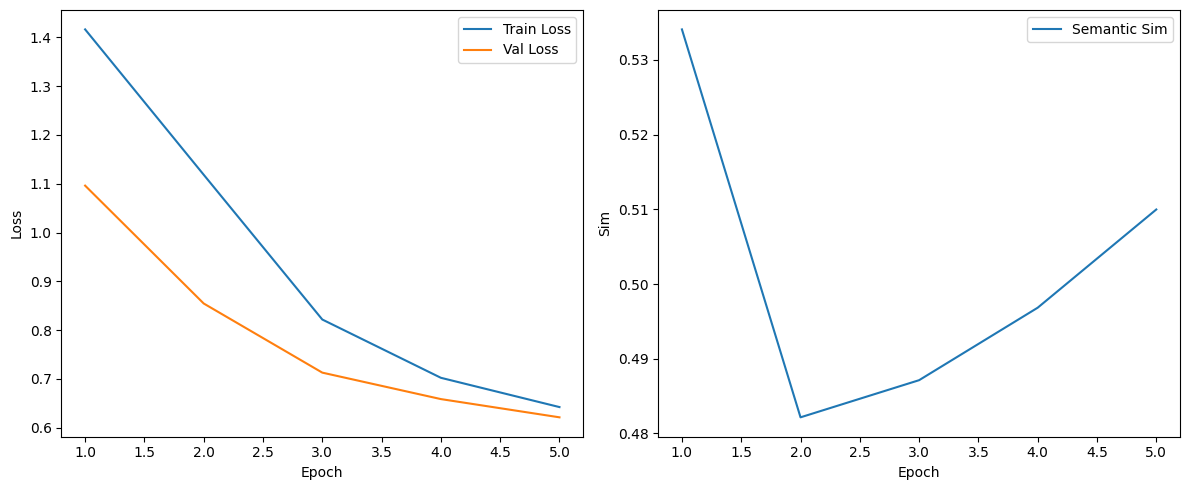


-- Phase 2, Epoch 1/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.5842
  Validation Loss     : 0.5801
  Semantic Similarity : 0.5092

-- Phase 2, Epoch 2/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.5643
  Validation Loss     : 0.5726
  Semantic Similarity : 0.5247

-- Phase 2, Epoch 3/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.5542
  Validation Loss     : 0.5692
  Semantic Similarity : 0.5233

-- Phase 2, Epoch 4/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.5500
  Validation Loss     : 0.5628
  Semantic Similarity : 0.5289

-- Phase 2, Epoch 5/5 --


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

  Train Loss          : 0.5466
  Validation Loss     : 0.5655
  Semantic Similarity : 0.5380


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.6106
Test Semantic Similarity: 0.5149

--- Example 212 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
Soft tissue swelling in medial aspect of left 1st MTP joint level._x000D_
No evidence of bone erosion._x000D_
Enthesophyte in plantar aspect of right calcaneus._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Soft tissue swelling in medial aspect of left 1st MTP joint level. No evidence of bone erosion. Enthesophyte in plantar aspect of right calcaneus.
Generated Report : 
 FINDINGS: No bony abnormality. 

--- Example 48 ---
Raw Report       : 
[ Finding ]_x000D_
no bony lesion._x000D_
[ Conclusion ]_x000D_
no bony lesion._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
no bony lesion.
Generated Report : 
 FINDINGS: both feet, OA. 

--- Example 160 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
accessory navicular bones, both, type 1._x000D_
_x000D_
[ Recommend ]_x000D_



In [9]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p         = patches.view(B*N, C, H, W)
        pf_feats  = (self.patch_encoder.forward_features(p)
                     if hasattr(self.patch_encoder, 'forward_features')
                     else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p       = pts.view(B*N, C, H, W)
            pf_feats= model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_   = model.attn(torch.cat([g,pf],1),
                                 torch.cat([g,pf],1),
                                 torch.cat([g,pf],1))
            comb     = model.norm(cat)

            # per-sample generation to avoid size mismatch
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m   = prompt_mask[i:i+1]
                enc = comb[i:i+1]
                enc_attn = torch.ones(1, enc.size(1), device=device)
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.7,
                    repetition_penalty=1.3,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with early cross‐attention unfreeze and frozen encoders
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE        = True
cfg.DATASET.AUGMENT        = True

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.bos_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# =============================================================================
# Freeze vision backbones
# =============================================================================
for p in model.global_encoder.parameters():
    p.requires_grad = False
for p in model.patch_encoder.parameters():
    p.requires_grad = False

# =============================================================================
# Phase 1: freeze everything except cross-attn + projection heads
# =============================================================================
for name, p in model.decoder.named_parameters():
    p.requires_grad = ("crossattention" in name.lower())
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze entire GPT-2, low‐LR fine‐tune
# =============================================================================
for p in model.decoder.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 5
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    prompt_text = f"{tokenizer.bos_token} FINDINGS:"
    prompt_ids  = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask = torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


2025-05-15 12:09:58.824293: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 12:09:58.830974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747336198.838715  103426 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747336198.841015  103426 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747336198.847007  103426 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


-- Epoch 1/1 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : nan
  Validation Loss     : nan
  Semantic Similarity : 0.0901


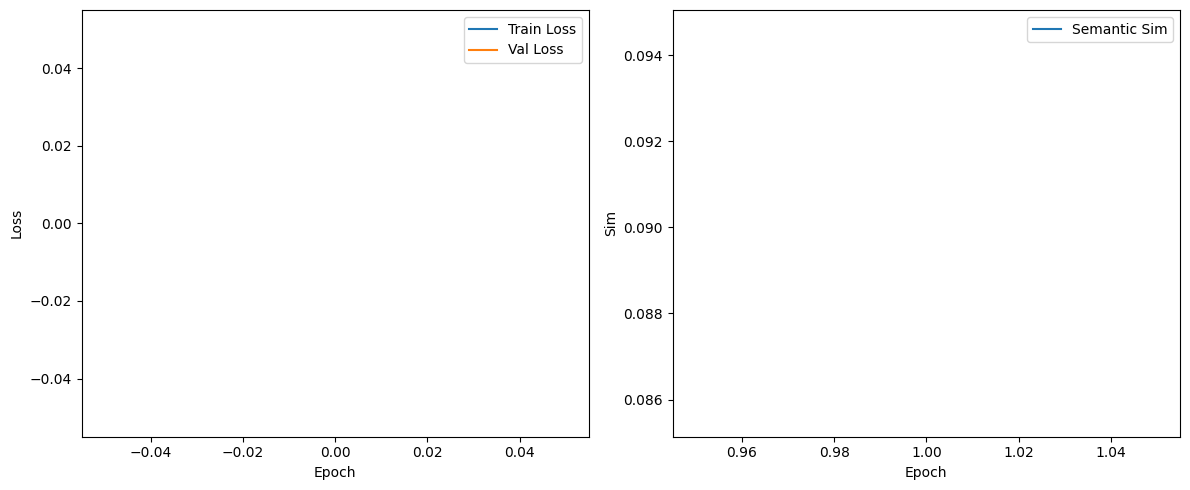

KeyboardInterrupt: 

In [1]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm

# pip install transformers bitsandbytes accelerate sentence-transformers
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import bitsandbytes as bnb
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")
        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")
        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Global tokenizer (for collate_fn and evaluation)
# =============================================================================
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
tokenizer.bos_token    = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token    = tokenizer.eos_token

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition: GPT2-medium quantized with projection layer
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2-medium'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)
        
        # Cross projection layer to match GPT-2's hidden dimension
        self.cross_proj     = nn.Linear(768, 1024)

        # Load GPT-2 without float16 to avoid precision issues
        self.decoder = GPT2LMHeadModel.from_pretrained(
            gpt2_model_name,
            add_cross_attention=True,
            load_in_8bit=True,
            device_map='auto',
            _fast_init=False
        )

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p         = patches.view(B*N, C, H, W)
        pf_feats  = (self.patch_encoder.forward_features(p)
                    if hasattr(self.patch_encoder, 'forward_features')
                    else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
        comb    = self.norm(cat)
        
        # Project to match GPT-2's hidden dimension
        comb_proj = self.cross_proj(comb)
        
        # Convert encoder outputs to match decoder's dtype
        decoder_dtype = next(p for p in self.decoder.parameters() if p.dtype.is_floating_point).dtype
        comb_proj = comb_proj.to(decoder_dtype)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb_proj,
            labels=decoder_labels
        )
        return out


# =============================================================================
# Training & evaluation loops (simplified to avoid precision issues)
# =============================================================================
def train_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        # Forward pass - regular precision
        out = model(imgs, pts, ids, msk, decoder_labels=ids)
        loss = out.loss
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p        = pts.view(B*N, C, H, W)
            pf_feats = (model.patch_encoder.forward_features(p)
                        if hasattr(model.patch_encoder, 'forward_features')
                        else model.patch_encoder(p))
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_   = model.attn(torch.cat([g,pf],1),
                                 torch.cat([g,pf],1),
                                 torch.cat([g,pf],1))
            comb    = model.norm(cat)
            comb_proj = model.cross_proj(comb)
            
            # Add these two lines here, before the generation loop
            decoder_dtype = next(p for p in model.decoder.parameters() if p.dtype.is_floating_point).dtype
            comb_proj = comb_proj.to(decoder_dtype)

            # per-sample generation
            prompt_ids  = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids  = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m = prompt_mask[i:i+1]
                enc = comb_proj[i:i+1]  # Use projected features
                
                # Convert attention mask to the same dtype as the model parameters
                decoder_dtype = next(p for p in model.decoder.parameters() if p.dtype.is_floating_point).dtype
                enc = enc.to(decoder_dtype)
                enc_attn = torch.ones(1, enc.size(1), device=device, dtype=decoder_dtype)
                
                # Change to greedy decoding to avoid multinomial sampling issues
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=False,  # Use greedy decoding instead of sampling
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN SCRIPT (simplified to a single training phase)
# =============================================================================
if __name__ == "__main__":
    # Set CUDA_LAUNCH_BLOCKING for better error messages
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    
    # Configuration
    class Cfg: pass
    cfg = Cfg()
    cfg.DATASET = Cfg()
    cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
    cfg.DATASET.USE_RAW        = True
    cfg.DATASET.USE_PATCH      = True
    cfg.DATASET.REPORT         = True
    cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
    cfg.DATASET.BALANCE        = True
    cfg.DATASET.AUGMENT        = False

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    # Dataset & tokenizer hookup
    dataset = FinalSamplesDataset(cfg)
    dataset.tokenizer = tokenizer
    dataset.eos_token = tokenizer.eos_token

    dist = Counter(e['class_label'] for e in dataset.data.values())
    for cls, cnt in dist.items():
        logging.info(f"  {cls}: {cnt}")

    # Train/val/test split
    n       = len(dataset)
    n_train = int(0.8 * n)
    n_val   = int(0.1 * n)
    n_test  = n - n_train - n_val
    train_ds, val_ds, test_ds = random_split(dataset, [n_train, n_val, n_test])

    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
    val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
    test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

    # Model
    model = MultiModalModel(gpt2_model_name='gpt2-medium')
    
    # Move vision modules & attention to GPU
    model.global_encoder = model.global_encoder.to(device)
    model.global_proj    = model.global_proj.to(device)
    model.patch_encoder  = model.patch_encoder.to(device)
    model.patch_proj     = model.patch_proj.to(device)
    model.attn           = model.attn.to(device)
    model.norm           = model.norm.to(device)
    model.cross_proj     = model.cross_proj.to(device)
    
    # Set trainable parameters - only train projection layers and cross-attention
    # Keep vision encoders frozen
    for p in model.global_encoder.parameters():
        p.requires_grad = False
    for p in model.patch_encoder.parameters():
        p.requires_grad = False
        
    # Make sure projection layers are trainable
    for p in model.global_proj.parameters():
        p.requires_grad = True
    for p in model.patch_proj.parameters():
        p.requires_grad = True
    for p in model.cross_proj.parameters():
        p.requires_grad = True
    for p in model.attn.parameters():
        p.requires_grad = True
    for p in model.norm.parameters():
        p.requires_grad = True
        
    # For decoder, make only cross-attention trainable
    for name, p in model.decoder.named_parameters():
        if "crossattention" in name.lower() and (p.dtype.is_floating_point or p.dtype.is_complex):
            p.requires_grad = True
        else:
            p.requires_grad = False

    # Optimizer and scheduler
    optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

    # Training loop - single phase, no mixed precision
    num_epochs = 1
    train_losses, val_losses, sems = [], [], []

    for epoch in range(num_epochs):
        print(f"\n-- Epoch {epoch+1}/{num_epochs} --")
        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
        sem = compute_semantic_similarity(gen_txt, gt_txt)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        sems.append(sem)

        print(f"  Train Loss          : {train_loss:.4f}")
        print(f"  Validation Loss     : {val_loss:.4f}")
        print(f"  Semantic Similarity : {sem:.4f}")
        scheduler.step()

    plot_metrics(train_losses, val_losses, sems)

    # Final test evaluation
    test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
    test_sem = compute_semantic_similarity(test_gen, test_gt)

    print("\n========== TEST RESULTS ==========")
    print(f"Test Loss               : {test_loss:.4f}")
    print(f"Test Semantic Similarity: {test_sem:.4f}")

    # Generate sample reports
    for idx in random.sample(range(len(test_ds)), min(3, len(test_ds))):
        ex    = test_ds[idx]
        raw   = ex['raw_report']
        clean = ex['cleaned_report']
        fi    = ex['full_img'].unsqueeze(0).to(device)
        pa    = ex['patches'].unsqueeze(0).to(device)

        # rebuild context
        g_feats = model.global_encoder(fi)
        g       = model.global_proj(g_feats).unsqueeze(1)
        B,N,C,H,W = pa.shape
        p        = pa.view(B*N, C, H, W)
        pf_feats = (model.patch_encoder.forward_features(p)
                    if hasattr(model.patch_encoder, 'forward_features')
                    else model.patch_encoder(p))
        pf_pooled= model._pool(pf_feats)
        pf        = model.patch_proj(pf_pooled).view(B, N, 768)
        cat,_   = model.attn(torch.cat([g,pf],1),
                             torch.cat([g,pf],1),
                             torch.cat([g,pf],1))
        comb    = model.norm(cat)
        comb_proj = model.cross_proj(comb)
        
        # Convert to appropriate dtype for the decoder
        decoder_dtype = next(p for p in model.decoder.parameters() if p.dtype.is_floating_point).dtype
        comb_proj = comb_proj.to(decoder_dtype)
        
        prompt_text = f"{tokenizer.bos_token} FINDINGS:"
        prompt_ids  = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
        prompt_mask = torch.ones_like(prompt_ids, device=device)
        
        # Create encoder attention mask with proper dtype
        enc_attn = torch.ones(1, comb_proj.size(1), device=device, dtype=decoder_dtype)
        
        # Use greedy decoding to avoid sampling issues
        gen_ids = model.decoder.generate(
            input_ids=prompt_ids,
            attention_mask=prompt_mask,
            encoder_hidden_states=comb_proj,
            encoder_attention_mask=enc_attn,
            max_length=150,
            do_sample=False,  # Switch to greedy decoding
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )
        gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

        print(f"\n--- Example {idx} ---")
        print(f"Raw Report       : \n{raw}")
        print(f"Cleaned Report   : \n{clean}")
        print(f"Generated Report : \n{gen}")


In [ ]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p         = patches.view(B*N, C, H, W)
        pf_feats  = (self.patch_encoder.forward_features(p)
                     if hasattr(self.patch_encoder, 'forward_features')
                     else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p       = pts.view(B*N, C, H, W)
            pf_feats= model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_   = model.attn(torch.cat([g,pf],1),
                                 torch.cat([g,pf],1),
                                 torch.cat([g,pf],1))
            comb     = model.norm(cat)

            # per-sample generation to avoid size mismatch
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m   = prompt_mask[i:i+1]
                enc = comb[i:i+1]
                enc_attn = torch.ones(1, enc.size(1), device=device)
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.7,
                    repetition_penalty=1.3,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with early cross‐attention unfreeze and frozen encoders
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE        = True
cfg.DATASET.AUGMENT        = True

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.bos_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# =============================================================================
# Freeze vision backbones
# =============================================================================
for p in model.global_encoder.parameters():
    p.requires_grad = False
for p in model.patch_encoder.parameters():
    p.requires_grad = False

# =============================================================================
# Phase 1: freeze everything except cross-attn + projection heads
# =============================================================================
for name, p in model.decoder.named_parameters():
    p.requires_grad = ("crossattention" in name.lower())
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze entire GPT-2, low‐LR fine‐tune
# =============================================================================
for p in model.decoder.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 5
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    prompt_text = f"{tokenizer.bos_token} FINDINGS:"
    prompt_ids  = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask = torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


2025-05-15 12:57:37.629540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-15 12:57:37.636141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747339057.643708  103756 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747339057.646005  103756 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747339057.651980  103756 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Reports successfully saved to all_dataset_reports.txt
Word frequency analysis saved to word_frequencies.txt


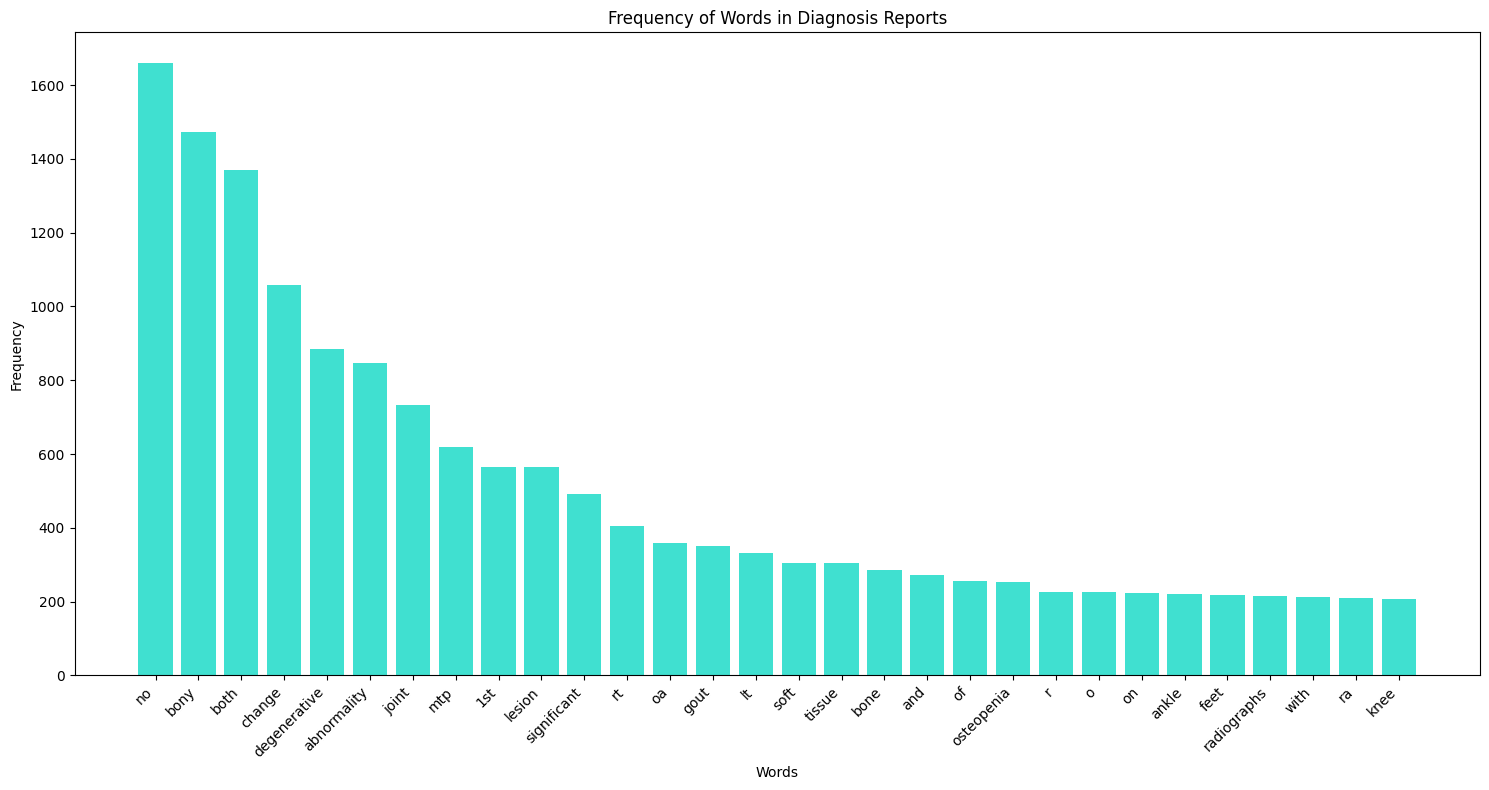

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


-- Phase 1, Epoch 1/5 --


KeyboardInterrupt: 

In [1]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

def save_reports_to_txt(dataset, output_file="all_reports.txt", include_generated=False, generated_reports=None):
    """
    Save all reports from the dataset to a text file
    
    Args:
        dataset: Dataset containing the reports
        output_file: Path to the output text file
        include_generated: Whether to include generated reports
        generated_reports: Optional list of generated reports
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("=== MEDICAL DIAGNOSIS REPORTS ===\n\n")
        
        for i, idx in enumerate(range(len(dataset))):
            sample = dataset[idx]
            f.write(f"=== REPORT {i+1} ===\n")
            #f.write(f"RAW REPORT:\n{sample['raw_report']}\n\n")
            f.write(f"CLEANED REPORT:\n{sample['cleaned_report']}\n\n")
            
            f.write("-" * 50 + "\n\n")
    
    print(f"Reports successfully saved to {output_file}")

def analyze_word_frequencies(dataset, output_file="word_frequencies.txt"):
    """Analyze and save word frequencies from all reports"""
    from collections import Counter
    import re
    
    all_words = []
    for idx in range(len(dataset)):
        sample = dataset[idx]
        text = sample['cleaned_report']
        # Convert to lowercase and split into words
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    
    # Count word frequencies
    word_counts = Counter(all_words)
    
    # Save to file
    with open(output_file, 'w') as f:
        f.write("WORD FREQUENCY ANALYSIS\n")
        f.write("======================\n\n")
        for word, count in word_counts.most_common():
            f.write(f"{word}: {count}\n")
    
    print(f"Word frequency analysis saved to {output_file}")
    
    # Plot word frequencies
    import matplotlib.pyplot as plt
    
    # Get the top 30 words for visualization
    top_words = dict(word_counts.most_common(30))
    plt.figure(figsize=(15, 8))
    plt.bar(top_words.keys(), top_words.values(), color='turquoise')
    plt.title('Frequency of Words in Diagnosis Reports')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('word_frequencies.png')
    plt.show()
    
    return word_counts


# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p         = patches.view(B*N, C, H, W)
        pf_feats  = (self.patch_encoder.forward_features(p)
                     if hasattr(self.patch_encoder, 'forward_features')
                     else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p       = pts.view(B*N, C, H, W)
            pf_feats= model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_   = model.attn(torch.cat([g,pf],1),
                                 torch.cat([g,pf],1),
                                 torch.cat([g,pf],1))
            comb     = model.norm(cat)

            # per-sample generation to avoid size mismatch
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m   = prompt_mask[i:i+1]
                enc = comb[i:i+1]
                enc_attn = torch.ones(1, enc.size(1), device=device)
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.7,
                    repetition_penalty=1.3,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with early cross‐attention unfreeze and frozen encoders
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE        = True
cfg.DATASET.AUGMENT        = True

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.bos_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)


# After creating the dataset
save_reports_to_txt(dataset, "all_dataset_reports.txt")
# Analyze word frequencies
word_counts = analyze_word_frequencies(dataset)



model = MultiModalModel().to(device)

# =============================================================================
# Freeze vision backbones
# =============================================================================
for p in model.global_encoder.parameters():
    p.requires_grad = False
for p in model.patch_encoder.parameters():
    p.requires_grad = False

# =============================================================================
# Phase 1: freeze everything except cross-attn + projection heads
# =============================================================================
for name, p in model.decoder.named_parameters():
    p.requires_grad = ("crossattention" in name.lower())
for p in model.global_proj.parameters():
    p.requires_grad = True
for p in model.patch_proj.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(filter(lambda x: x.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze entire GPT-2, low‐LR fine‐tune
# =============================================================================
for p in model.decoder.parameters():
    p.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 5
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# Final test
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    prompt_text = f"{tokenizer.bos_token} FINDINGS:"
    prompt_ids  = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask = torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Counting dataset: 100%|██████████| 1714/1714 [00:00<00:00, 746447.62it/s]
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.cross


-- Phase 1, Epoch 1/1 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 2.3445
  Validation Loss     : 1.3597
  Semantic Similarity : 0.4949


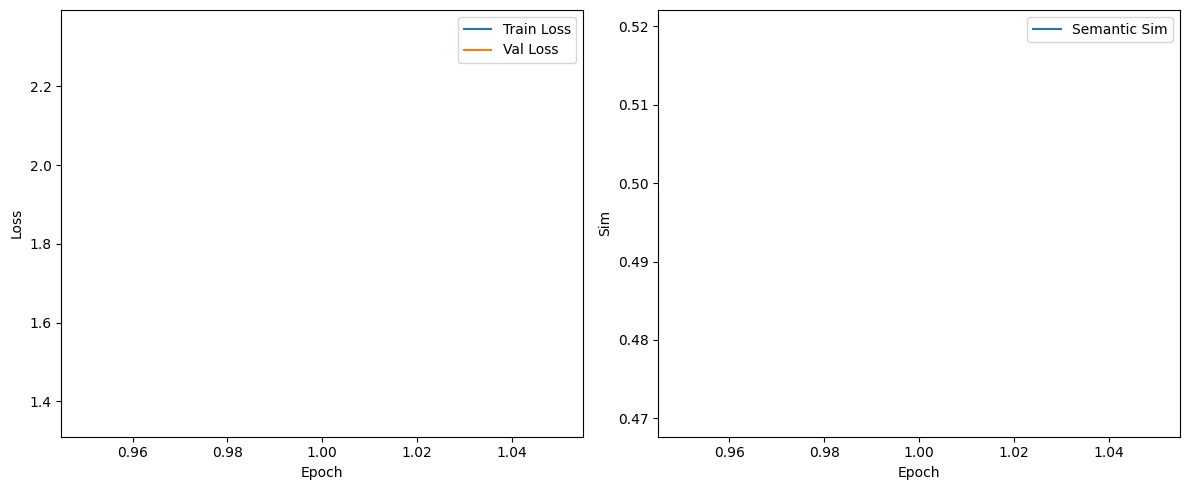


-- Phase 2, Epoch 1/1 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 1.3826
  Validation Loss     : 1.3478
  Semantic Similarity : 0.5124


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 1.2910
Test Semantic Similarity: 0.5512

--- Example 106 ---
Raw Report       : 
[ Finding ]_x000D_
_x000D_
[ Diagnosis ]_x000D_
Soft tissue swelling of both lateral malleolar area and right 1st MTP joint._x000D_
Osteoarthritis of both 1st MTP joint._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
Soft tissue swelling of both lateral malleolar area and right 1st MTP joint. Osteoarthritis of both 1st MTP joint.
Generated Report : 
 FINDINGS: no bony lesion. 

--- Example 24 ---
Raw Report       : 
[ Finding ]_x000D_
no bony lesion._x000D_
[ Diagnosis ]_x000D_
no bony lesion._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
no bony lesion. no bony lesion.
Generated Report : 
 FINDINGS: degenerative change ------------- Osteosarcoma. ------------------- Bilateral oedema, no bony abnormality but radiocordination with both knees bent out and left arm open on right thigh at elbow 3rd level of 1st joint ---------------------------

In [6]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Add PEFT imports for LoRA
from peft import LoraConfig, get_peft_model, TaskType

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition with LoRA
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        # load GPT-2 with cross-attention
        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p         = patches.view(B*N, C, H, W)
        pf_feats  = (self.patch_encoder.forward_features(p)
                     if hasattr(self.patch_encoder, 'forward_features')
                     else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (unchanged)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p       = pts.view(B*N, C, H, W)
            pf_feats= model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_   = model.attn(torch.cat([g,pf],1),
                                 torch.cat([g,pf],1),
                                 torch.cat([g,pf],1))
            comb     = model.norm(cat)

            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m   = prompt_mask[i:i+1]
                enc = comb[i:i+1]
                enc_attn = torch.ones(1, enc.size(1), device=device)
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.7,
                    repetition_penalty=1.3,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with LoRA on GPT-2 cross-attention
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE        = True
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.bos_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Instantiate dataset
dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# Build model and apply LoRA
model = MultiModalModel().to(device)

# Freeze visual encoders and non-LoRA decoder parameters
for p in model.global_encoder.parameters():
    p.requires_grad = False
for p in model.patch_encoder.parameters():
    p.requires_grad = False
for p in model.global_proj.parameters():
    p.requires_grad = False
for p in model.patch_proj.parameters():
    p.requires_grad = False

# Define LoRA config targeting GPT-2's cross-attention q and v projections
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,             # LoRA rank
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["c_attn"]  # GPT-2 uses a combined c_attn; PEFT will split internally
)
model.decoder = get_peft_model(model.decoder, lora_config)

# Phase 1: only LoRA adapters are trainable
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 1
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze also the projection heads + LayerNorm; keep visual encoders frozen
# =============================================================================
for name, p in model.named_parameters():
    # Unfreeze global/patch projection and LayerNorm and LoRA; keep visual backbones frozen
    if any(nd in name for nd in ["global_proj", "patch_proj", "norm", "lora"]):
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 1
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# =============================================================================
# Final test
# =============================================================================
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    prompt_text = f"{tokenizer.bos_token} FINDINGS:"
    prompt_ids  = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask = torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


Counting dataset: 100%|██████████| 1714/1714 [00:00<00:00, 764547.17it/s]
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.cross


-- Phase 1, Epoch 1/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 1.9182
  Validation Loss     : 1.0553
  Semantic Similarity : 0.5387

-- Phase 1, Epoch 2/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 1.1372
  Validation Loss     : 0.9148
  Semantic Similarity : 0.4734

-- Phase 1, Epoch 3/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.9893
  Validation Loss     : 0.8276
  Semantic Similarity : 0.5037

-- Phase 1, Epoch 4/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.8902
  Validation Loss     : 0.7859
  Semantic Similarity : 0.3994

-- Phase 1, Epoch 5/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.8305
  Validation Loss     : 0.7477
  Semantic Similarity : 0.4765


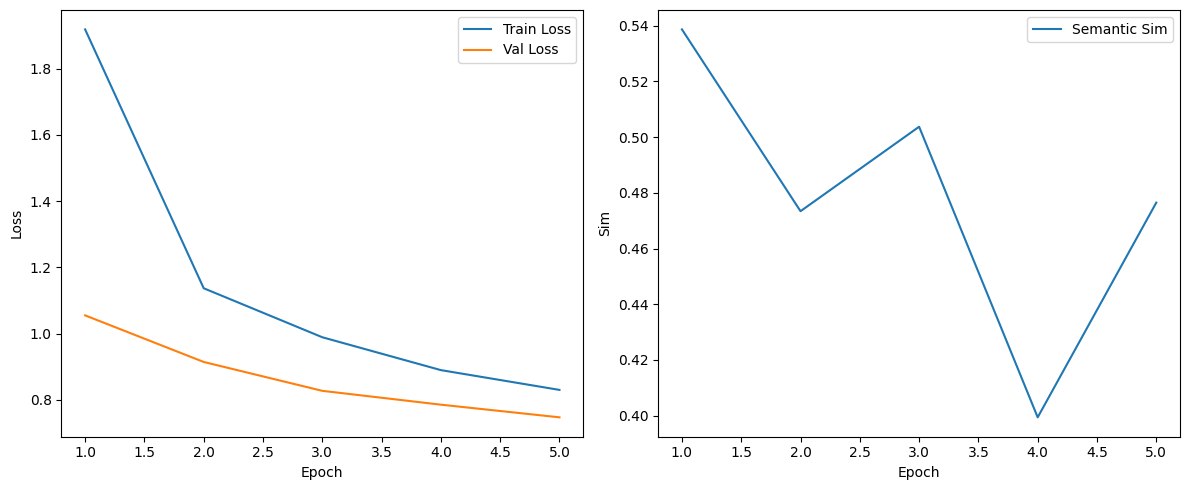


-- Phase 2, Epoch 1/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.7907
  Validation Loss     : 0.7408
  Semantic Similarity : 0.4943

-- Phase 2, Epoch 2/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.8067
  Validation Loss     : 0.7384
  Semantic Similarity : 0.4853

-- Phase 2, Epoch 3/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.7921
  Validation Loss     : 0.7370
  Semantic Similarity : 0.4641

-- Phase 2, Epoch 4/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.7849
  Validation Loss     : 0.7374
  Semantic Similarity : 0.4997

-- Phase 2, Epoch 5/5 --


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

  Train Loss          : 0.7931
  Validation Loss     : 0.7373
  Semantic Similarity : 0.4967


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/5 [00:00<?, ?it/s]


========== TEST RESULTS ==========
Test Loss               : 0.7336
Test Semantic Similarity: 0.5162

--- Example 106 ---
Raw Report       : 
[ Finding ]_x000D_
degenerative change._x000D_
[ Diagnosis ]_x000D_
degenerative change._x000D_
[ Recommend ]_x000D_

Cleaned Report   : 
degenerative change. degenerative change.
Generated Report : 
 FINDINGS: No bony lesion. -------------------------- no abnormality, both feet and wrists ------------------------------------------ mild gout arthritis (diastolic bone swelling) at left ankle joint Lt 1st MTP joints Rt/O RA involvement with degenerative change of right wrist base soft tissue erosion in lateral portion of calcaneal proximal phalanx ------------------------------------------------------------------------ type 2 accessory navicular bones rp OA site osteopenia --- hallux valgus medial aspect --> possible dearthritic changes on radiographs from T1 fracture along warts < 5th MT area moderate to low thickness erosions periartisial effusi

In [3]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Add PEFT imports for LoRA
from peft import LoraConfig, get_peft_model, TaskType

# =============================================================================
# Logging configuration: write INFO+ logs only to training.log (no console output)
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition with LoRA
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj    = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder  = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj     = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn           = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm           = nn.LayerNorm(768)

        # load GPT-2 with cross-attention
        self.decoder        = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g       = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p         = patches.view(B*N, C, H, W)
        pf_feats  = (self.patch_encoder.forward_features(p)
                     if hasattr(self.patch_encoder, 'forward_features')
                     else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf        = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                           torch.cat([g,pf],1),
                           torch.cat([g,pf],1))
        comb    = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops (unchanged)
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts  = b['patches'].to(device)
        ids  = b['input_ids'].to(device)
        msk  = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g       = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p       = pts.view(B*N, C, H, W)
            pf_feats= model.patch_encoder(p)
            pf_pooled= model._pool(pf_feats)
            pf        = model.patch_proj(pf_pooled).view(B, N, 768)
            cat,_   = model.attn(torch.cat([g,pf],1),
                                 torch.cat([g,pf],1),
                                 torch.cat([g,pf],1))
            comb     = model.norm(cat)

            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m   = prompt_mask[i:i+1]
                enc = comb[i:i+1]
                enc_attn = torch.ones(1, enc.size(1), device=device)
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.7,
                    repetition_penalty=1.3,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt .extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1  = stm.encode(gen, convert_to_tensor=True)
    e2  = stm.encode(gt,  convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: two‐phase training with LoRA on GPT-2 cross-attention
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON           = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW        = True
cfg.DATASET.USE_PATCH      = True
cfg.DATASET.REPORT         = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE        = True
cfg.DATASET.AUGMENT        = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.bos_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token     = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

# Instantiate dataset
dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token  = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")

n       = len(dataset)
n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=4, shuffle=False, collate_fn=collate_fn)

# Build model and apply LoRA
model = MultiModalModel().to(device)

# Freeze visual encoders and non-LoRA decoder parameters
for p in model.global_encoder.parameters():
    p.requires_grad = False
for p in model.patch_encoder.parameters():
    p.requires_grad = False
for p in model.global_proj.parameters():
    p.requires_grad = False
for p in model.patch_proj.parameters():
    p.requires_grad = False

# Define LoRA config targeting GPT-2's cross-attention q and v projections
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,             # LoRA rank
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["c_attn", "c_proj"]  # GPT-2 uses a combined c_attn; PEFT will split internally
)
model.decoder = get_peft_model(model.decoder, lora_config)

# Phase 1: only LoRA adapters are trainable
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler    = torch.amp.GradScaler()

phase1_epochs = 5
train_losses, val_losses, sems = [], [], []

for epoch in range(phase1_epochs):
    print(f"\n-- Phase 1, Epoch {epoch+1}/{phase1_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# =============================================================================
# Phase 2: unfreeze also the projection heads + LayerNorm; keep visual encoders frozen
# =============================================================================
for name, p in model.named_parameters():
    # Unfreeze global/patch projection and LayerNorm and LoRA; keep visual backbones frozen
    if any(nd in name for nd in ["global_proj", "patch_proj", "norm", "lora"]):
        p.requires_grad = True

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)
scaler    = torch.amp.GradScaler()

phase2_epochs = 5
for epoch in range(phase2_epochs):
    print(f"\n-- Phase 2, Epoch {epoch+1}/{phase2_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

# =============================================================================
# Final test
# =============================================================================
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Random examples
for idx in random.sample(range(len(test_ds)), min(30, len(test_ds))):
    ex    = test_ds[idx]
    raw   = ex['raw_report']
    clean = ex['cleaned_report']
    fi    = ex['full_img'].unsqueeze(0).to(device)
    pa    = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g       = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p      = pa.view(B*N, C, H, W)
    pf_feats= model.patch_encoder(p)
    pf_pooled= model._pool(pf_feats)
    pf        = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_  = model.attn(torch.cat([g,pf],1),
                        torch.cat([g,pf],1),
                        torch.cat([g,pf],1))
    comb    = model.norm(cat)

    prompt_text = f"{tokenizer.bos_token} FINDINGS:"
    prompt_ids  = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask = torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")


In [10]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Import PEFT for LoRA implementation
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

# =============================================================================
# Logging configuration
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    print(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    print(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition with LoRA
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # Vision encoders
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        
        # Initialize base GPT-2 model with cross-attention
        base_decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        
        # Configure LoRA
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=16,                  # Low rank dimension
            lora_alpha=32,         # Scaling factor
            lora_dropout=0.05,     # Dropout probability
            target_modules=["c_attn", "c_proj"],  # Apply to attention modules
            bias="none"
        )
        
        # Apply LoRA to the model
        self.decoder = get_peft_model(base_decoder, lora_config)
        
        # Print trainable parameters info
        self.print_trainable_parameters()
    
    def print_trainable_parameters(self):
        """
        Prints the number of trainable parameters in the model.
        """
        trainable_params = 0
        all_param = 0
        for _, param in self.decoder.named_parameters():
            all_param += param.numel()
            if param.requires_grad:
                trainable_params += param.numel()
        
        logging.info(
            f"GPT-2 with LoRA trainable params: {trainable_params} || all params: {all_param} || "
            f"trainable%: {100 * trainable_params / all_param:.2f}%"
        )

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                   if hasattr(self.patch_encoder, 'forward_features')
                   else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                          torch.cat([g,pf],1),
                          torch.cat([g,pf],1))
        comb = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat, _ = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb = model.norm(cat)

            # per-sample generation to avoid size mismatch
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m = prompt_mask[i:i+1]
                enc = comb[i:i+1]
                enc_attn = torch.ones(1, enc.size(1), device=device)
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.7,
                    repetition_penalty=1.3,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: LoRA fine-tuning with frozen vision encoders
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.bos_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# Freeze vision backbones
for p in model.global_encoder.parameters():
    p.requires_grad = False
for p in model.patch_encoder.parameters():
    p.requires_grad = False

# Setup optimizer for trainable parameters only (LoRA parameters + projection heads)
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.amp.GradScaler()

# Training loop with LoRA
num_epochs = 10
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\n-- Epoch {epoch+1}/{num_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# Save LoRA weights
#model.decoder.save_pretrained("lora_gpt2_medical_model")

# Final test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Generate examples from test set
for idx in random.sample(range(len(test_ds)), min(5, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_ = model.attn(torch.cat([g,pf],1),
                      torch.cat([g,pf],1),
                      torch.cat([g,pf],1))
    comb = model.norm(cat)

    prompt_text = f"{tokenizer.bos_token} FINDINGS:"
    prompt_ids = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask = torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")

# Load and use the saved LoRA weights
def load_lora_model():
    base_model = GPT2LMHeadModel.from_pretrained('gpt2', add_cross_attention=True)
    lora_model = PeftModel.from_pretrained(base_model, "lora_gpt2_medical_model")
    return lora_model

# If you want to merge the LoRA weights with the base model for faster inference
def merge_and_save():
    model = load_lora_model()
    model = model.merge_and_unload()  # This merges the LoRA weights into the base model
    model.save_pretrained("merged_gpt2_medical_model")


Counting dataset: 100%|██████████| 1714/1714 [00:00<00:00, 651771.27it/s]


  abnormal: 966
  normal: 748

Number of training samples:   1371
Number of validation samples: 171
Number of test samples:       172
Total samples:                1714



Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


-- Epoch 1/10 --


KeyboardInterrupt: 

In [12]:
import os
import re
import json
import unicodedata
import random
import logging
from collections import defaultdict, Counter

import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import timm
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Import PEFT for LoRA implementation
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

# =============================================================================
# Logging configuration
# =============================================================================
for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)
logging.basicConfig(
    filename='training.log',
    filemode='w',
    level=logging.INFO,
    format='%(asctime)s %(levelname)-8s %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# =============================================================================
# Utility functions
# =============================================================================
def count_labels(data, target_classes, cfg):
    class_counts = defaultdict(int)
    data_by_class = defaultdict(list)
    for entry in tqdm(data.values(), desc="Counting dataset"):
        lbl = entry.get('class_label', '').lower()
        if lbl in target_classes and os.path.exists(entry['file_path']):
            class_counts[lbl] += 1
            data_by_class[lbl].append(entry)
    return class_counts, data_by_class

def prepare_abnormal_normal_data(data, cfg):
    random.seed(42)
    class_counts, data_by_class = count_labels(data, ['abnormal', 'normal'], cfg)
    combined = {
        'abnormal': data_by_class.get('abnormal', []),
        'normal':   data_by_class.get('normal',   [])
    }
    combined_counts = {
        'abnormal': class_counts.get('abnormal', 0),
        'normal':   class_counts.get('normal',   0)
    }
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(combined.values(), []), combined_counts, combined_counts
    min_count = min(combined_counts.values())
    balanced, final_counts = [], {}
    for lbl, items in combined.items():
        sampled = random.sample(items, min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, combined_counts, final_counts

def prepare_data(data, target_classes, cfg, is_binary=False):
    random.seed(42)
    if is_binary and len(target_classes) == 2 and 'abnormal' in target_classes:
        logging.info("Using abnormal-vs-normal logic")
        return prepare_abnormal_normal_data(data, cfg)
    class_counts, data_by_class = count_labels(data, target_classes, cfg)
    logging.info(f"Original class distribution: {class_counts}")
    print(f"Original class distribution: {class_counts}")
    if not cfg.DATASET.BALANCE and not cfg.DATASET.AUGMENT:
        return sum(data_by_class.values(), []), class_counts, class_counts
    min_count = min(class_counts.values())
    balanced, final_counts = [], {}
    for lbl in target_classes:
        sampled = random.sample(data_by_class[lbl], min_count)
        balanced.extend(sampled)
        final_counts[lbl] = min_count
    logging.info(f"Balanced class distribution: {final_counts}")
    print(f"Balanced class distribution: {final_counts}")
    if cfg.DATASET.AUGMENT:
        balanced = balanced * 2
        for lbl in final_counts:
            final_counts[lbl] *= 2
    return balanced, class_counts, final_counts

# =============================================================================
# Transforms
# =============================================================================
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
patch_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# =============================================================================
# Dataset (binary abnormal vs normal)
# =============================================================================
class FinalSamplesDataset(Dataset):
    def __init__(self, cfg, image_transform=train_transform, patch_transform=patch_transform):
        self.cfg = cfg
        self.image_transform = image_transform
        self.patch_transform = patch_transform

        self.target_classes = cfg.DATASET.TARGET_CLASSES
        if isinstance(self.target_classes, str):
            self.target_classes = self.target_classes.split(",")

        self.is_binary = len(self.target_classes) == 2 and 'abnormal' in self.target_classes
        self.abnormal_mapping = (
            {
                'ra':   'abnormal',
                'oa':   'abnormal',
                'gout': 'abnormal',
                'oa, ra':               'abnormal',
                'combination of oa, ra':'abnormal',
                'uncertain': 'abnormal',
                'ref.prev' : 'abnormal',
                'normal':'normal'
            }
            if self.is_binary else None
        )

        with open(cfg.DATASET.JSON, 'r') as f:
            raw_list = json.load(f)

        filtered = []
        for item in raw_list:
            merged = item.get('merged_image_path', '')
            fp = item.get('file_paths', [])
            if isinstance(fp, str):
                fp = [fp]
            paths = [merged] + fp
            if any(os.path.exists(p) for p in paths):
                filtered.append((merged, fp, item))

        self.data = {}
        idx = 0
        for merged, fp, item in filtered:
            raw_cls = item.get('class', 'unknown').lower()
            if self.abnormal_mapping:
                if raw_cls not in self.abnormal_mapping:
                    continue
                cls = self.abnormal_mapping[raw_cls]
            else:
                if raw_cls not in self.target_classes:
                    continue
                cls = raw_cls

            self.data[idx] = {
                'file_path': merged,
                'left_right_file_path': fp,
                'class_label': cls,
                'diagnosis': item.get('diagnosis', ''),
                'keypoints': item.get('keypoints', {})
            }
            idx += 1

        if self.is_binary:
            balanced, _, _ = prepare_data(self.data, self.target_classes, cfg, True)
            self.data = {i: e for i, e in enumerate(balanced)}

        self.tokenizer = None
        self.eos_token = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        e = self.data[idx]
        img = Image.open(e['file_path']).convert('RGB')
        img = self.image_transform(img)
        logging.info(f"[Dataset] full_img shape: {img.shape}")

        patches = self._gen_patches(e['left_right_file_path'], e['keypoints'])
        pt = [self.patch_transform(Image.fromarray(p)) for p in patches]
        patches_tensor = torch.stack(pt, 0) if pt else torch.zeros(34, 3, 112, 112)
        logging.info(f"[Dataset] patches_tensor shape: {patches_tensor.shape}")

        raw = e.get('diagnosis', '')
        clean = self._clean_report(raw)

        input_text = f"{self.tokenizer.bos_token} FINDINGS: {clean} {self.tokenizer.eos_token}"
        tok = self.tokenizer(input_text, truncation=True, max_length=512, return_tensors='pt')

        input_ids      = tok['input_ids'].squeeze(0)
        attention_mask = tok['attention_mask'].squeeze(0)
        logging.info(f"[Dataset] input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")

        return {
            'full_img':       img,
            'patches':        patches_tensor,
            'raw_report':     raw,
            'cleaned_report': clean,
            'input_ids':      input_ids,
            'attention_mask': attention_mask
        }

    def _gen_patches(self, paths, kps_dict, crop_size=(200, 300), patch_size=(112, 112)):
        def extract(arr, side_kps):
            lst = []
            pts = side_kps[0]['keypoints']
            for i in range(17):
                x, y, s = int(pts[3*i]), int(pts[3*i+1]), pts[3*i+2]
                if s > 0:
                    x0 = max(x - crop_size[0]//2, 0)
                    y0 = max(y - crop_size[1]//2, 0)
                    x1 = min(x + crop_size[0]//2, arr.shape[1])
                    y1 = min(y + crop_size[1]//2, arr.shape[0])
                    c = arr[y0:y1, x0:x1]
                    if c.size:
                        lst.append(cv2.resize(c, patch_size))
            return lst

        def pad17(lst):
            black = np.zeros((patch_size[1], patch_size[0], 3), np.uint8)
            while len(lst) < 17:
                lst.append(black)
            return lst[:17]

        left, right = [], []
        if len(paths) == 1:
            pth = paths[0]
            if not pth or not os.path.exists(pth):
                return pad17([]) + pad17([])
            img_arr = cv2.imread(pth)
            if img_arr is None:
                return pad17([]) + pad17([])
            arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
            if kps_dict.get('left'):  left  = extract(arr, kps_dict['left'])
            if kps_dict.get('right'): right = extract(arr, kps_dict['right'])
        else:
            for side, pth in zip(['left','right'], paths):
                if pth and os.path.exists(pth):
                    img_arr = cv2.imread(pth)
                    if img_arr is not None:
                        arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                        if kps_dict.get(side):
                            lst = extract(arr, kps_dict[side])
                            if side=='left':  left  = lst
                            else:             right = lst

        if left and not right:
            right = [cv2.flip(p,1) for p in left]
        if right and not left:
            left  = [cv2.flip(p,1) for p in right]
        if not left and not right:
            return pad17([]) + pad17([])

        return pad17(left) + pad17(right)

    def _clean_report(self, text):
        text = unicodedata.normalize('NFKC', text or '')
        text = re.sub(r'(?m)^-+\s*$', '', text)
        text = re.sub(r'[^\x00-\x7F]+', ' ', text)
        text = re.sub(r'([.!?]){2,}', r'\1', text)
        text = re.sub(r'\[\s*finding\s*\]', '[FINDING]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*conclusion\s*\]', '[CONCLUSION]', text, flags=re.IGNORECASE)
        text = re.sub(r'\[\s*diagnosis\s*\]', '[DIAGNOSIS]', text, flags=re.IGNORECASE)
        parts = re.split(r'\[\s*recommend(?:ation)?\s*\]', text, flags=re.IGNORECASE)
        text = parts[0]
        fm = re.search(r'\[FINDING\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        cm = re.search(r'\[CONCLUSION\](.*?)(?=\[|$)', text, flags=re.IGNORECASE|re.DOTALL)
        if fm and cm and fm.group(1).strip().lower() == cm.group(1).strip().lower():
            text = re.sub(r'\[CONCLUSION\].*?(?=\[|$)', '', text, flags=re.IGNORECASE|re.DOTALL)
        text = re.sub(r'\[\s*(FINDING|CONCLUSION|DIAGNOSIS)\s*\]', '', text, flags=re.IGNORECASE)
        text = text.replace('_x000D_', ' ')
        return re.sub(r'\s+', ' ', text).strip()

# =============================================================================
# Collate function
# =============================================================================
def collate_fn(batch):
    imgs = torch.stack([b['full_img'] for b in batch])
    logging.info(f"[Collate] imgs: {imgs.shape}")

    pts = [b['patches'] for b in batch]
    max_p = max(p.shape[0] for p in pts)
    pads = []
    for p in pts:
        if p.shape[0] < max_p:
            pad = torch.zeros((max_p - p.shape[0], *p.shape[1:]))
            p = torch.cat([p, pad], dim=0)
        pads.append(p)
    patches = torch.stack(pads, 0)
    logging.info(f"[Collate] patches: {patches.shape}")

    ids   = [b['input_ids'] for b in batch]
    masks = [b['attention_mask'] for b in batch]
    ids   = nn.utils.rnn.pad_sequence(ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    masks = nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)
    logging.info(f"[Collate] ids: {ids.shape}, masks: {masks.shape}")

    return {
        'full_imgs':       imgs,
        'patches':         patches,
        'input_ids':       ids,
        'attention_mask':  masks,
        'raw_reports':     [b['raw_report']     for b in batch],
        'cleaned_reports': [b['cleaned_report'] for b in batch]
    }

# =============================================================================
# Model definition with LoRA
# =============================================================================
class MultiModalModel(nn.Module):
    def __init__(self, gpt2_model_name='gpt2'):
        super().__init__()
        # Vision encoders
        self.global_encoder = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.global_encoder.reset_classifier(0)
        self.global_proj = nn.Linear(self.global_encoder.num_features, 768)

        self.patch_encoder = timm.create_model('resnet50', pretrained=True)
        self.patch_encoder.fc = nn.Identity()
        self.patch_proj = nn.Linear(self.patch_encoder.num_features, 768)

        self.attn = nn.MultiheadAttention(embed_dim=768, num_heads=8, batch_first=True)
        self.norm = nn.LayerNorm(768)
        
        # Initialize base GPT-2 model with cross-attention
        base_decoder = GPT2LMHeadModel.from_pretrained(gpt2_model_name, add_cross_attention=True)
        
        # Configure LoRA
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=16,                  # Low rank dimension
            lora_alpha=32,         # Scaling factor
            lora_dropout=0.05,     # Dropout probability
            target_modules=["c_attn", "c_proj"],  # Apply to attention modules
            bias="none"
        )
        
        # Apply LoRA to the model
        self.decoder = get_peft_model(base_decoder, lora_config)
        
        # Print trainable parameters info
        self.print_trainable_parameters()
    
    def print_trainable_parameters(self):
        """
        Prints the number of trainable parameters in the model.
        """
        trainable_params = 0
        all_param = 0
        for _, param in self.decoder.named_parameters():
            all_param += param.numel()
            if param.requires_grad:
                trainable_params += param.numel()
        
        logging.info(
            f"GPT-2 with LoRA trainable params: {trainable_params} || all params: {all_param} || "
            f"trainable%: {100 * trainable_params / all_param:.2f}%"
        )

    def _pool(self, feats):
        return feats.mean(dim=[2,3]) if feats.ndim > 2 else feats

    def forward(self, imgs, patches, input_ids, attention_mask, decoder_labels=None):
        g_feats = self.global_encoder(imgs)
        g = self.global_proj(g_feats).unsqueeze(1)

        B,N,C,H,W = patches.shape
        p = patches.view(B*N, C, H, W)
        pf_feats = (self.patch_encoder.forward_features(p)
                   if hasattr(self.patch_encoder, 'forward_features')
                   else self.patch_encoder(p))
        pf_pooled = self._pool(pf_feats)
        pf = self.patch_proj(pf_pooled).view(B, N, 768)

        cat, _ = self.attn(torch.cat([g,pf],1),
                          torch.cat([g,pf],1),
                          torch.cat([g,pf],1))
        comb = self.norm(cat)

        out = self.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=comb,
            labels=decoder_labels
        )
        return out

# =============================================================================
# Training & evaluation loops
# =============================================================================
def train_epoch(model, loader, optimizer, scaler, device):
    model.train()
    total_loss = 0.
    for b in tqdm(loader, desc="Training", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            loss = out.loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.
    all_gen, all_gt = [], []
    for b in tqdm(loader, desc="Evaluating", leave=False):
        imgs = b['full_imgs'].to(device)
        pts = b['patches'].to(device)
        ids = b['input_ids'].to(device)
        msk = b['attention_mask'].to(device)

        with torch.no_grad():
            out = model(imgs, pts, ids, msk, decoder_labels=ids)
            total_loss += out.loss.item()

            # rebuild visual context
            g_feats = model.global_encoder(imgs)
            g = model.global_proj(g_feats).unsqueeze(1)
            B,N,C,H,W = pts.shape
            p = pts.view(B*N, C, H, W)
            pf_feats = model.patch_encoder(p)
            pf_pooled = model._pool(pf_feats)
            pf = model.patch_proj(pf_pooled).view(B, N, 768)
            cat, _ = model.attn(torch.cat([g,pf],1),
                                torch.cat([g,pf],1),
                                torch.cat([g,pf],1))
            comb = model.norm(cat)

            # per-sample generation to avoid size mismatch
            prompt_ids = tokenizer("FINDINGS:", return_tensors="pt", add_special_tokens=False).input_ids.to(device)
            prompt_ids = prompt_ids.expand(B, -1)
            prompt_mask = torch.ones_like(prompt_ids, device=device)

            gen_txt = []
            for i in range(B):
                inp = prompt_ids[i:i+1]
                m = prompt_mask[i:i+1]
                enc = comb[i:i+1]
                enc_attn = torch.ones(1, enc.size(1), device=device)
                out_ids = model.decoder.generate(
                    input_ids=inp,
                    attention_mask=m,
                    encoder_hidden_states=enc,
                    encoder_attention_mask=enc_attn,
                    max_length=150,
                    do_sample=True,
                    top_p=0.9,
                    temperature=0.7,
                    repetition_penalty=1.3,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.eos_token_id
                )
                gen_txt.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))

            gt_txt = [tokenizer.decode(i_, skip_special_tokens=True) for i_ in ids]
            all_gen.extend(gen_txt)
            all_gt.extend(gt_txt)

    return total_loss / len(loader), all_gen, all_gt

def compute_semantic_similarity(gen, gt):
    stm = SentenceTransformer('all-MiniLM-L6-v2')
    e1 = stm.encode(gen, convert_to_tensor=True)
    e2 = stm.encode(gt, convert_to_tensor=True)
    return nn.functional.cosine_similarity(e1, e2).mean().item()

def plot_metrics(train_losses, val_losses, sems):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, sems, label="Semantic Sim")
    plt.xlabel("Epoch"); plt.ylabel("Sim"); plt.legend()
    plt.tight_layout(); plt.show()

# =============================================================================
# MAIN: LoRA fine-tuning with frozen vision encoders
# =============================================================================
class Cfg: pass
cfg = Cfg()
cfg.DATASET = Cfg()
cfg.DATASET.JSON = 'final_samples_both_only_v2.json'
cfg.DATASET.USE_RAW = True
cfg.DATASET.USE_PATCH = True
cfg.DATASET.REPORT = True
cfg.DATASET.TARGET_CLASSES = ['abnormal','normal']
cfg.DATASET.BALANCE = False
cfg.DATASET.AUGMENT = False

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.bos_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

dataset = FinalSamplesDataset(cfg)
dataset.tokenizer = tokenizer
dataset.eos_token = tokenizer.eos_token

dist = Counter(e['class_label'] for e in dataset.data.values())
for cls,cnt in dist.items():
    logging.info(f"  {cls}: {cnt}")
    print(f"  {cls}: {cnt}")

n = len(dataset)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val
train_ds, val_ds, test_ds = random_split(dataset, [n_train,n_val,n_test])

# print sample counts
print(f"\nNumber of training samples:   {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")
print(f"Number of test samples:       {len(test_ds)}")
print(f"Total samples:                {len(train_ds) + len(val_ds) + len(test_ds)}\n")

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

model = MultiModalModel().to(device)

# Freeze vision backbones
for p in model.global_encoder.parameters():
    p.requires_grad = False
for p in model.patch_encoder.parameters():
    p.requires_grad = False

# Setup optimizer for trainable parameters only (LoRA parameters + projection heads)
optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
scaler = torch.amp.GradScaler()

# Training loop with LoRA
num_epochs = 20
train_losses, val_losses, sems = [], [], []

for epoch in range(num_epochs):
    print(f"\n-- Epoch {epoch+1}/{num_epochs} --")
    train_loss = train_epoch(model, train_loader, optimizer, scaler, device)
    val_loss, gen_txt, gt_txt = evaluate(model, val_loader, device)
    sem = compute_semantic_similarity(gen_txt, gt_txt)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    sems.append(sem)

    print(f"  Train Loss          : {train_loss:.4f}")
    print(f"  Validation Loss     : {val_loss:.4f}")
    print(f"  Semantic Similarity : {sem:.4f}")
    scheduler.step()

plot_metrics(train_losses, val_losses, sems)

# Save LoRA weights
#model.decoder.save_pretrained("lora_gpt2_medical_model")

# Final test evaluation
test_loss, test_gen, test_gt = evaluate(model, test_loader, device)
test_sem = compute_semantic_similarity(test_gen, test_gt)

print("\n========== TEST RESULTS ==========")
print(f"Test Loss               : {test_loss:.4f}")
print(f"Test Semantic Similarity: {test_sem:.4f}")

# Generate examples from test set
for idx in random.sample(range(len(test_ds)), min(5, len(test_ds))):
    ex = test_ds[idx]
    raw = ex['raw_report']
    clean = ex['cleaned_report']
    fi = ex['full_img'].unsqueeze(0).to(device)
    pa = ex['patches'].unsqueeze(0).to(device)

    g_feats = model.global_encoder(fi)
    g = model.global_proj(g_feats).unsqueeze(1)
    B,N,C,H,W = pa.shape
    p = pa.view(B*N, C, H, W)
    pf_feats = model.patch_encoder(p)
    pf_pooled = model._pool(pf_feats)
    pf = model.patch_proj(pf_pooled).view(B,N,768)
    cat,_ = model.attn(torch.cat([g,pf],1),
                      torch.cat([g,pf],1),
                      torch.cat([g,pf],1))
    comb = model.norm(cat)

    prompt_text = f"{tokenizer.bos_token} FINDINGS:"
    prompt_ids = tokenizer(prompt_text, return_tensors="pt", add_special_tokens=False).input_ids.to(device)
    prompt_mask = torch.ones_like(prompt_ids, device=device)
    gen_ids = model.decoder.generate(
        input_ids=prompt_ids,
        attention_mask=prompt_mask,
        encoder_hidden_states=comb,
        encoder_attention_mask=torch.ones(1, comb.size(1), device=device),
        max_length=150,
        do_sample=True,
        top_p=0.9,
        temperature=0.7,
        repetition_penalty=1.3,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    gen = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {idx} ---")
    print(f"Raw Report       : \n{raw}")
    print(f"Cleaned Report   : \n{clean}")
    print(f"Generated Report : \n{gen}")

# Load and use the saved LoRA weights
def load_lora_model():
    base_model = GPT2LMHeadModel.from_pretrained('gpt2', add_cross_attention=True)
    lora_model = PeftModel.from_pretrained(base_model, "lora_gpt2_medical_model")
    return lora_model

# If you want to merge the LoRA weights with the base model for faster inference
def merge_and_save():
    model = load_lora_model()
    model = model.merge_and_unload()  # This merges the LoRA weights into the base model
    model.save_pretrained("merged_gpt2_medical_model")


Counting dataset: 100%|██████████| 2394/2394 [00:00<00:00, 705435.14it/s]


  abnormal: 1646
  normal: 748

Number of training samples:   1915
Number of validation samples: 239
Number of test samples:       240
Total samples:                2394



Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat


-- Epoch 1/20 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.7469
  Validation Loss     : 1.1070
  Semantic Similarity : 0.4667

-- Epoch 2/20 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.1399
  Validation Loss     : 0.9318
  Semantic Similarity : 0.4377

-- Epoch 3/20 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 1.0239
  Validation Loss     : 0.8605
  Semantic Similarity : 0.4430

-- Epoch 4/20 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.9437
  Validation Loss     : 0.8230
  Semantic Similarity : 0.4672

-- Epoch 5/20 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.8817
  Validation Loss     : 0.7911
  Semantic Similarity : 0.4794

-- Epoch 6/20 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.8536
  Validation Loss     : 0.7682
  Semantic Similarity : 0.4810

-- Epoch 7/20 --


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

  Train Loss          : 0.8317
  Validation Loss     : 0.7522
  Semantic Similarity : 0.4652

-- Epoch 8/20 --


KeyboardInterrupt: 